In [189]:
import pandas as pd

data= pd.read_parquet('D:\\traffic_forecasting\\Data\\yellow_tripdata_2024-01.parquet')

In [190]:
data.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.00
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.00
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.00
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.00
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.00
5,1,2024-01-01 00:54:08,2024-01-01 01:26:31,1.0,4.70,1.0,N,148,141,1,29.6,3.5,0.5,6.90,0.0,1.0,41.50,2.5,0.00
6,2,2024-01-01 00:49:44,2024-01-01 01:15:47,2.0,10.82,1.0,N,138,181,1,45.7,6.0,0.5,10.00,0.0,1.0,64.95,0.0,1.75
7,1,2024-01-01 00:30:40,2024-01-01 00:58:40,0.0,3.00,1.0,N,246,231,2,25.4,3.5,0.5,0.00,0.0,1.0,30.40,2.5,0.00
8,2,2024-01-01 00:26:01,2024-01-01 00:54:12,1.0,5.44,1.0,N,161,261,2,31.0,1.0,0.5,0.00,0.0,1.0,36.00,2.5,0.00
9,2,2024-01-01 00:28:08,2024-01-01 00:29:16,1.0,0.04,1.0,N,113,113,2,3.0,1.0,0.5,0.00,0.0,1.0,8.00,2.5,0.00


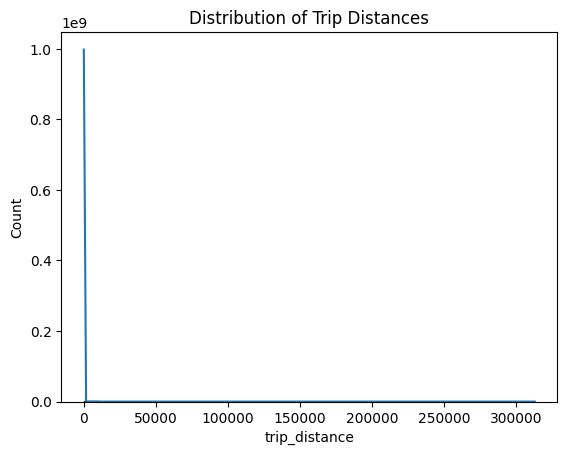

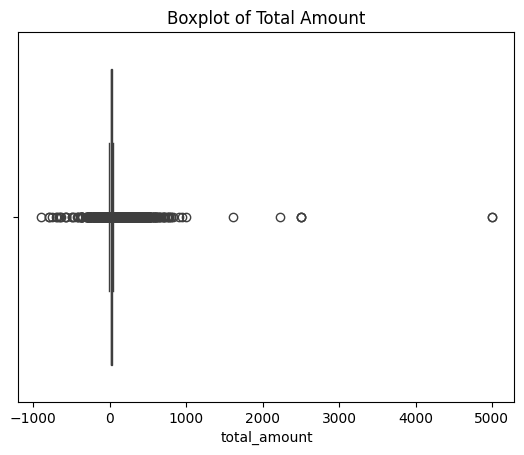

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of trip distances
sns.histplot(data['trip_distance'], bins=30, kde=True)
plt.title('Distribution of Trip Distances')
plt.show()

# Boxplot for total_amount
sns.boxplot(x=data['total_amount'])
plt.title('Boxplot of Total Amount')
plt.show()


In [102]:
data.isna().sum()

VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          140162
trip_distance                 0
RatecodeID               140162
store_and_fwd_flag       140162
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     140162
Airport_fee              140162
dtype: int64

In [174]:
data = data.dropna(subset=['passenger_count', 'trip_distance', 'fare_amount'])

In [175]:
data['trip_duration'] = (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).dt.total_seconds() / 60

In [176]:
data['pickup_hour'] = data['tpep_pickup_datetime'].dt.hour
data['pickup_day_of_week'] = data['tpep_pickup_datetime'].dt.dayofweek
data['pickup_month'] = data['tpep_pickup_datetime'].dt.month
data['distance_per_minute'] = data['trip_distance'] / (data['trip_duration'] + 1e-5)  # Avoid division by zero



In [177]:
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])

In [134]:
!pip install geopy

  Obtaining dependency information for geopy from https://files.pythonhosted.org/packages/e5/15/cf2a69ade4b194aa524ac75112d5caac37414b20a3a03e6865dfe0bd1539/geopy-2.4.1-py3-none-any.whl.metadata
  Obtaining dependency information for geographiclib<3,>=1.52 from https://files.pythonhosted.org/packages/9f/5a/a26132406f1f40cf51ea349a5f11b0a46cec02a2031ff82e391c2537247a/geographiclib-2.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/125.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/125.4 kB ? eta -:--:--
   --- ------------------------------------ 10.2/125.4 kB ? eta -:--:--
   ------------------- ------------------- 61.4/125.4 kB 544.7 kB/s eta 0:00:01
   -------------------------------------- 125.4/125.4 kB 817.0 kB/s eta 0:00:00
   ---------------------------------------- 0.0/40.3 kB ? eta -:--:--
   ---------------------------------------- 40.3/40.3 kB 1.9 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [136]:
# from geopy.distance import geodesic

# def haversine_distance(pu, do):
#     return geodesic(pu, do).km

# data['distance_haversine'] = data.apply(
#     lambda row: haversine_distance((row['pickup_lat'], row['pickup_lon']),
#                                    (row['dropoff_lat'], row['dropoff_lon'])), axis=1
# )


In [178]:
data.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee', 'trip_duration',
       'pickup_hour', 'pickup_day_of_week', 'pickup_month',
       'distance_per_minute'],
      dtype='object')

In [179]:

# Select relevant columns
columns_to_use = [
    'VendorID', 'passenger_count', 'trip_distance', 'RatecodeID', 
    'PULocationID', 'DOLocationID', 'fare_amount', 'extra', 
    'mta_tax', 'congestion_surcharge', 'trip_duration','pickup_hour',
    'pickup_day_of_week', 'pickup_month','distance_per_minute'
]
df = data[columns_to_use]

# Display the first few rows
# print(df.head())


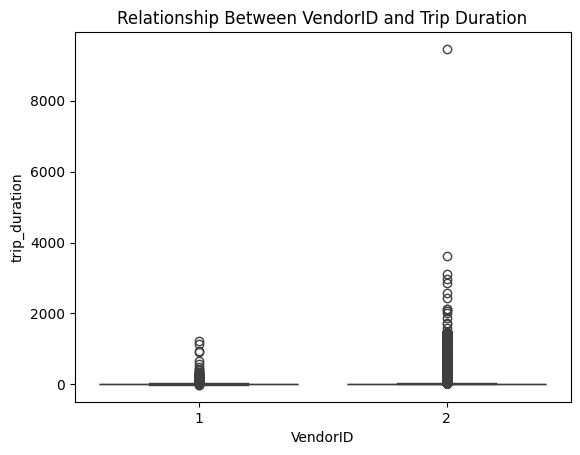

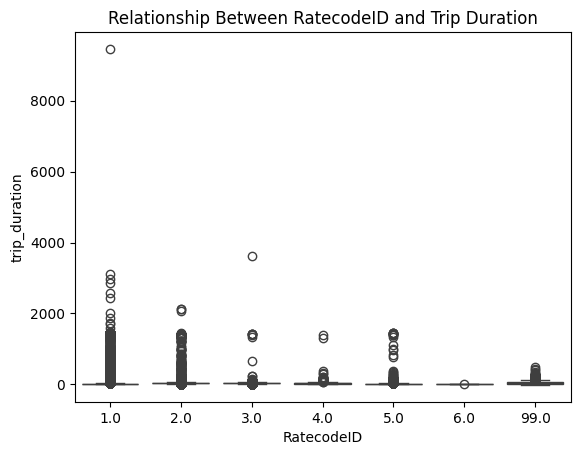

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='VendorID', y='trip_duration', data=df)
plt.title("Relationship Between VendorID and Trip Duration")
plt.show()

sns.boxplot(x='RatecodeID', y='trip_duration', data=df)
plt.title("Relationship Between RatecodeID and Trip Duration")
plt.show()


In [180]:
from sklearn.preprocessing import OneHotEncoder

encoder= OneHotEncoder()
#We are encoding these despite them being numerical is becasue they represent the labels or the group so it is better to encode them 
# encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')


rate_encoded = encoder.fit_transform(df[['RatecodeID']])
# Convert into dense matrix as Onehotencoding produces sparse mmatrix
rate_encoded= rate_encoded.toarray()
rate_encoded_columns = encoder.get_feature_names_out(['RatecodeID'])


# print(len(rate_encoded_columns))

vendor_encoded = encoder.fit_transform(df[['VendorID']])
vendor_encoded=vendor_encoded.toarray()

vendor_encoded_columns = encoder.get_feature_names_out(['VendorID'])

rate_encoded_df = pd.DataFrame(rate_encoded, columns=rate_encoded_columns)
vendor_encoded_df = pd.DataFrame(vendor_encoded, columns=vendor_encoded_columns)


In [181]:
df= pd.concat([df,rate_encoded_df,vendor_encoded_df], axis=1)


In [182]:
df.drop(columns=['RatecodeID', 'VendorID'])

,passenger_count,trip_distance,PULocationID,DOLocationID,fare_amount,extra,mta_tax,congestion_surcharge,trip_duration,pickup_hour,...,distance_per_minute,RatecodeID_1.0,RatecodeID_2.0,RatecodeID_3.0,RatecodeID_4.0,RatecodeID_5.0,RatecodeID_6.0,RatecodeID_99.0,VendorID_1,VendorID_2
0,1.0,1.72,186,79,17.7,1.0,0.5,2.5,19.800000,0,...,0.086869,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,1.80,140,236,10.0,3.5,0.5,2.5,6.600000,0,...,0.272727,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,4.70,236,79,23.3,3.5,0.5,2.5,17.916667,0,...,0.262325,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,1.40,79,211,10.0,3.5,0.5,2.5,8.300000,0,...,0.168674,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.80,211,148,7.9,3.5,0.5,2.5,6.100000,0,...,0.131147,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2824457,1.0,3.51,138,129,16.3,6.0,0.5,0.0,8.033333,23,...,0.436929,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2824458,1.0,3.36,162,261,18.4,1.0,0.5,2.5,16.516667,23,...,0.203431,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2824459,3.0,3.30,43,249,17.7,3.5,0.5,2.5,16.783333,23,...,0.196624,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2824460,0.0,0.40,142,163,5.1,3.5,0.5,2.5,3.400000,23,...,0.117647,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [183]:
X = df.drop(columns=['trip_duration'])  # All columns except the target
y = df['trip_duration']  # The target variable

In [184]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [185]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
!pip install xgboost


In [170]:
!pip install xgboost==1.7.6
!pip install scikit-learn==1.3.0


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [187]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the XGBoost Regressor
xgb_reg = xgb.XGBRegressor(
    n_estimators=100,  # Number of trees
    learning_rate=0.1,  # Step size shrinkage
    max_depth=6,  # Maximum depth of a tree
    subsample=0.8,  # Fraction of samples used per tree
    colsample_bytree=0.8,  # Fraction of features used per tree
    random_state=42
)

# Fit the model
xgb_reg.fit(X_train_scaled, y_train)

# Make predictions
y_pred = xgb_reg.predict(X_test_scaled)

# Evaluate
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R²: {r2}")


RMSE: 175.4240086126961
R²: 0.8518576612218705


In [161]:
!pip install --upgrade scikit-learn xgboost



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [186]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
}

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(random_state=42),  # New instance of XGBRegressor
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_squared_error',  # Use negative MSE for scoring
    n_jobs=-1  # Utilize all CPUs
)

# Fit GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Output the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score (neg MSE):", grid_search.best_score_)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

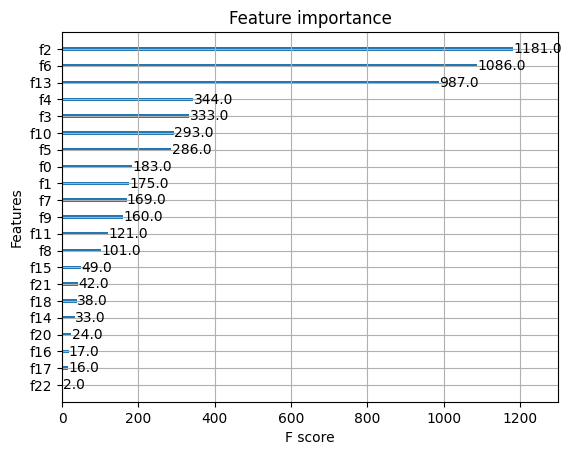

In [188]:
from xgboost import plot_importance
plot_importance(xgb_reg)  # Visualize feature importance


In [ ]:
# from sklearn.linear_model import LinearRegression
# model= LinearRegression()
# model.fit(X_train_scaled, y_train)

LinearRegression()

In [89]:
# from sklearn.ensemble import RandomForestRegressor

# model = RandomForestRegressor(random_state=42)
# model.fit(X_train_scaled, y_train)


In [91]:
from sklearn.metrics import mean_squared_error, r2_score

# Predict on the test set
y_pred = model.predict(X_test_scaled)

# Calculate RMSE and R^2
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R^2: {r2}")


RMSE: 1104.3350306778834
R^2: 0.06740944108491398
